#### 20250401
#### Tuesday

### E0322038
### Apurva Lisbeth Joseph

# CA 4
# Brain tumor classification

### Install libraries

In [1]:
!pip install deap

### Import libraries

In [2]:
# General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import os, requests, cv2, random

# Genetic algorithms
from deap import base, creator, tools, algorithms

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Image processing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Pre-trained models
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

### Set seeds for reproducibility

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

### Create file paths

In [4]:
train_data_dir = r"C:\Users\alisj_w232e84\Downloads\datasets\braintumor\Training"
test_data_dir = r"C:\Users\alisj_w232e84\Downloads\datasets\braintumor\Testing"

### Set hyperparameters

In [5]:
IMG_SIZE = (100, 100)
BATCH_SIZE = 16
EPOCHS = 50

### Data augmentation

In [6]:
train_data_gen = ImageDataGenerator(
    rescale=1/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3
)

test_data_gen = ImageDataGenerator(
    rescale=1/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

### Creating generators for loading and processing images

In [7]:
# Training data generator
train_gen = train_data_gen.flow_from_directory(
    train_data_dir,
    target_size=(100, 100),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    subset='training'
)

Found 4000 images belonging to 4 classes.


In [8]:
# Validation data generator
val_gen = train_data_gen.flow_from_directory(
    train_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    subset='validation'
)

Found 1712 images belonging to 4 classes.


In [9]:
# Test data generator
test_gen = test_data_gen.flow_from_directory(
    test_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1311 images belonging to 4 classes.


## Model definition

### 1. CNN model
#### 4 Conv2D + 4 MaxPooling2D + Flatten + Dropout + 2 Dense layers

In [10]:
def create_cnn():
  cnn_model = Sequential()

  # First convolutional layer
  cnn_model.add(
      Conv2D(
          64,
          kernel_size=(3, 3),
          activation='relu',
          input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
          )
      )

  # First pooling layer
  cnn_model.add(
      MaxPooling2D(
          pool_size=(2, 2)
          )
      )

  # Second convolutional layer
  cnn_model.add(
      Conv2D(
          64,
          kernel_size=(3, 3),
          activation='relu'
          )
      )

  # Second pooling layer
  cnn_model.add(
      MaxPooling2D(
          pool_size=(2, 2)
          )
      )

  # Third convolutional layer
  cnn_model.add(
      Conv2D(
          64,
          kernel_size=(3, 3),
          activation='relu',
          )
      )

  # Third pooling layer
  cnn_model.add(
      MaxPooling2D(
          pool_size=(2, 2)
          )
      )

  # Fourth convolutional layer
  cnn_model.add(
      Conv2D(
          64,
          kernel_size=(3, 3),
          activation='relu'
          )
      )

  # Fourth pooling layer
  cnn_model.add(
      MaxPooling2D(
          pool_size=(2, 2)
          )
      )

  # Flatten layer
  cnn_model.add(
      Flatten()
  )

  # Dropout layer
  cnn_model.add(
      Dropout(0.5)
  )

  # First dense layer (128 neurons)
  cnn_model.add(
      Dense(
          128,
          activation='relu'
      )
  )

  # Second dense layer (4 neurons)
  cnn_model.add(
      Dense(
          4,
          activation='softmax'
      )
  )

  return cnn_model

# Create CNN model
cnn_model = create_cnn()

# Display the model summary
cnn_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 64)       

### 2. AlexNet

In [11]:
def create_alexnet():
    alexnet_model = Sequential()

    # First Convolutional Layer
    alexnet_model.add(
        Conv2D(
            96,
            kernel_size=(11, 11),
            strides=(4, 4),
            activation='relu',
            input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
            )
        )
    alexnet_model.add(
        MaxPooling2D(
            pool_size=(3, 3),
            strides=(2, 2)
            )
        )

    # Second Convolutional Layer
    alexnet_model.add(
        Conv2D(
            256,
             (5, 5),
            padding="same",
            activation='relu'
            )
        )
    alexnet_model.add(
        MaxPooling2D(
            pool_size=(3, 3),
            strides=(2, 2)
            )
        )

    # Third Convolutional Layer
    alexnet_model.add(
        Conv2D(
            384,
             kernel_size=(3, 3),
            padding="same",
            activation='relu'
            )
        )

    # Fourth Convolutional Layer
    alexnet_model.add(
        Conv2D(
            384,
            kernel_size=(3, 3),
            padding="same",
            activation='relu'
            )
        )

    # Fifth Convolutional Layer
    alexnet_model.add(
        Conv2D(256,
               kernel_size=(3, 3),
               padding="same",
               activation='relu'
               )
        )
    alexnet_model.add(
        MaxPooling2D(
            pool_size=(3, 3),
            strides=(2, 2)
            )
        )

    # Flatten Layer
    alexnet_model.add(
        Flatten()
        )

    # Fully Connected Layers
    alexnet_model.add(
        Dense(
            4096,
            activation='relu'
            )
        )

    alexnet_model.add(
        Dropout(0.5)
        )

    alexnet_model.add(
        Dense(
            4096,
            activation='relu'
            )
        )

    alexnet_model.add(
        Dropout(0.5)
        )

    alexnet_model.add(
        Dense(
            4,
            activation='softmax'
            )
        )

    return alexnet_model

# Create AlexNet model
alexnet_model = create_alexnet()

# Display the model summary
alexnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 23, 23, 96)        34944     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 11, 11, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 256)       614656    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 5, 256)         0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 5, 5, 384)         885120    
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 5, 384)        

### 3. VGG-16

In [12]:
def create_vgg():
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

    for layer in base_model.layers:
        layer.trainable = False  # Freeze VGG16 layers

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(4, activation="softmax")(x)  # 4 classes

    return Model(inputs=base_model.input, outputs=output)

# Create VGG model
vgg_model = create_vgg()

# Display the model summary
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

### 4. ResNet50

In [13]:
def create_resnet():
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

    for layer in base_model.layers:
        layer.trainable = False  # Freeze ResNet50 layers

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(4, activation="softmax")(x)  # 4 classes

    return Model(inputs=base_model.input, outputs=output)

# Create ResNet model
resnet_model = create_resnet()

# Display the model summary
resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 106, 106, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 50, 50, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 50, 50, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

### 5. InceptionV3

In [14]:
def create_inception():
    base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

    for layer in base_model.layers:
        layer.trainable = False  # Freeze InceptionV3 layers

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(4, activation="softmax")(x)  # 4 classes

    return Model(inputs=base_model.input, outputs=output)

# Create Inception model
inception_model = create_inception()

# Display the model summary
inception_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 49, 49, 32)           864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 49, 49, 32)           96        ['conv2d_9[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 49, 49, 32)           0         ['batch_normalization[0]

### Custom hyperparameters for each model 

In [15]:
model_configs = {
    "cnn": {
        "learning_rate": 0.0005,
        "batch_size": 16,
        "dropout": 0.3
    },
    "alexnet": {
        "learning_rate": 0.0001,
        "batch_size": 16,
        "dropout": 0.5
    },
    "vgg": {
        "learning_rate": 0.0001,
        "batch_size": 16,
        "dropout": 0.4
    },
    "resnet": {
        "learning_rate": 0.00005,
        "batch_size": 16,
        "dropout": 0.5
    },
    "inception": {
        "learning_rate": 0.0001,
        "batch_size": 16,
        "dropout": 0.4
    }
}

### Training model

In [16]:
def train_model(model, model_name, config):
    opt = Adam(learning_rate=config["learning_rate"])
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=5,
        restore_best_weights=True
    )

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=[early_stopping]
    )

    # model.save(f"{model_name}.h5")
    return history

### Plot training and validation loss and accuracy

In [17]:
def plot_training_history(history, model_name):
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], 'r', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'b', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(0, len(epochs) + 1, 10))
    plt.title(f'Training and Validation Loss - {model_name}')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], 'r', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(range(0, len(epochs) + 1, 10))
    plt.title(f'Training and Validation Accuracy - {model_name}')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Evaluate model

In [18]:
def evaluate_model(model, model_name):
    test_steps_per_epoch = math.ceil(test_gen.samples / test_gen.batch_size)

    predictions = model.predict(test_gen, steps=test_steps_per_epoch)

    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_gen.classes
    class_labels = list(test_gen.class_indices.keys())

    # Evaluation metrics
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average="macro")
    recall = recall_score(true_classes, predicted_classes, average="macro")
    f1 = f1_score(true_classes, predicted_classes, average="macro")

    print(f"\nAccuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    print(f"\nClassification Report for {model_name}:\n", classification_report(true_classes, predicted_classes, target_names=class_labels))

    # Plot Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # Visualize sample classifications
    visualize_predictions(test_gen, model, predicted_classes, class_labels, model_name)

### Randomly visualize predictions

In [19]:
def visualize_predictions(test_gen, model, predicted_classes, class_labels, model_name):
    # Get all filepaths and true labels
    image_paths = test_gen.filepaths
    true_classes = test_gen.classes

    # Randomly select images ensuring different true labels
    unique_classes = list(set(true_classes))
    selected_indices = []
    for cls in unique_classes:
        indices = np.where(true_classes == cls)[0]  # Get indices for each class
        selected_indices.extend(random.sample(list(indices), min(2, len(indices))))  # Pick 2 per class (adjust as needed)

    # Load the selected images and their labels
    selected_images = []
    selected_true_labels = []
    for idx in selected_indices:
        img = load_img(image_paths[idx], target_size=IMG_SIZE)
        img_array = img_to_array(img) / 255.0
        selected_images.append(img_array)
        selected_true_labels.append(true_classes[idx])

    selected_images = np.array(selected_images)

    # Get model predictions
    predicted_probs = model.predict(selected_images)
    predicted_labels = np.argmax(predicted_probs, axis=1)

    # Plot results
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle(f"True vs Predicted Labels - {model_name}", fontsize=14)

    for i, ax in enumerate(axes.flat):
        if i >= len(selected_images):
            break
        ax.imshow(selected_images[i])
        ax.set_title(f"True: {class_labels[selected_true_labels[i]]}\nPred: {class_labels[predicted_labels[i]]}", fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

## Model results

### 1. CNN model

Epoch 1/50


250/250 [==============================] - 117s 444ms/step - loss: 0.9792 - accuracy: 0.5430 - val_loss: 1.0296 - val_accuracy: 0.6075
Epoch 2/50
250/250 [==============================] - 102s 407ms/step - loss: 0.6281 - accuracy: 0.7445 - val_loss: 0.8491 - val_accuracy: 0.7079
Epoch 3/50
250/250 [==============================] - 107s 429ms/step - loss: 0.5291 - accuracy: 0.7895 - val_loss: 0.8298 - val_accuracy: 0.7249
Epoch 4/50
250/250 [==============================] - 105s 421ms/step - loss: 0.4586 - accuracy: 0.8150 - val_loss: 0.7549 - val_accuracy: 0.7617
Epoch 5/50
250/250 [==============================] - 110s 442ms/step - loss: 0.4163 - accuracy: 0.8400 - val_loss: 0.6796 - val_accuracy: 0.7553
Epoch 6/50
250/250 [==============================] - 96s 382ms/step - loss: 0.3675 - accuracy: 0.8577 - val_loss: 0.7368 - val_accuracy: 0.7716
Epoch 7/50
250/250 [==============================] - 99s 396ms/step - loss: 0.3369 - accuracy: 0.8740 - val_loss: 0.6538 -

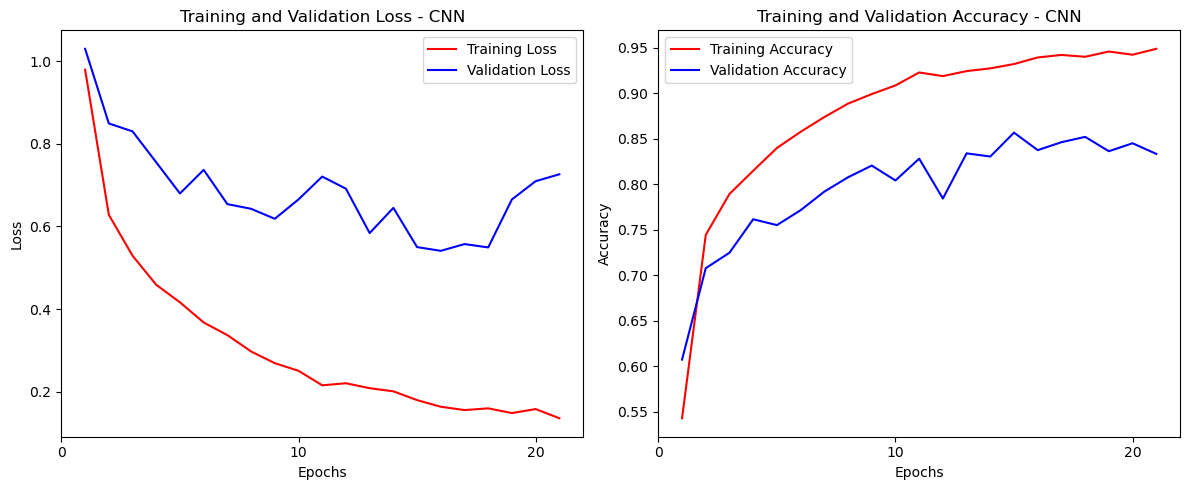

82/82 [==============================] - 32s 378ms/step

Accuracy: 0.8680396643783371
Precision: 0.873734437592365
Recall: 0.8610657225853304
F1-Score: 0.861079714190611

Classification Report for CNN:
               precision    recall  f1-score   support

      glioma       0.96      0.73      0.83       300
  meningioma       0.82      0.77      0.80       306
     notumor       0.88      0.95      0.92       405
   pituitary       0.83      0.99      0.90       300

    accuracy                           0.87      1311
   macro avg       0.87      0.86      0.86      1311
weighted avg       0.87      0.87      0.87      1311



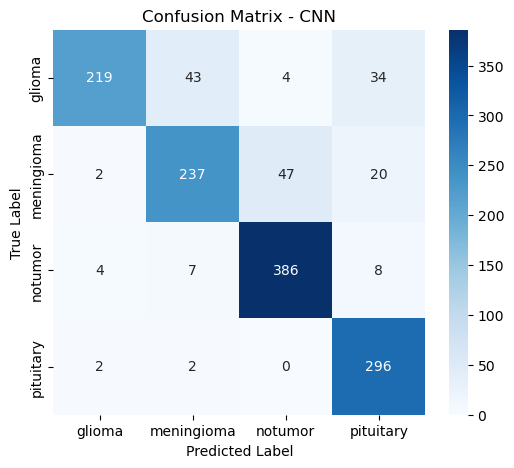

1/1 [==============================] - 0s 401ms/step


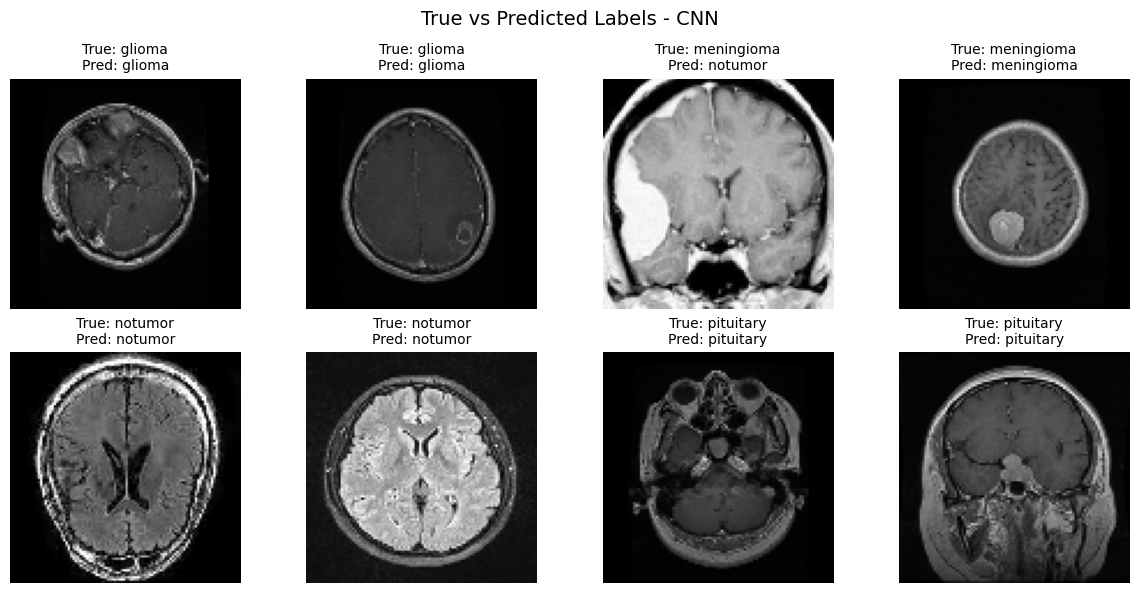

In [20]:
history_cnn = train_model(cnn_model, "CNN", model_configs["cnn"])
plot_training_history(history_cnn, "CNN")
evaluate_model(cnn_model, "CNN")

### 2. AlexNet

Epoch 1/50
250/250 [==============================] - 211s 832ms/step - loss: 0.9831 - accuracy: 0.5092 - val_loss: 1.0098 - val_accuracy: 0.5806
Epoch 2/50
250/250 [==============================] - 239s 956ms/step - loss: 0.6471 - accuracy: 0.7025 - val_loss: 1.2068 - val_accuracy: 0.5520
Epoch 3/50
250/250 [==============================] - 194s 777ms/step - loss: 0.5752 - accuracy: 0.7492 - val_loss: 1.0728 - val_accuracy: 0.6338
Epoch 4/50
250/250 [==============================] - 190s 752ms/step - loss: 0.5047 - accuracy: 0.7862 - val_loss: 1.0007 - val_accuracy: 0.6817
Epoch 5/50
250/250 [==============================] - 214s 859ms/step - loss: 0.4476 - accuracy: 0.8148 - val_loss: 0.8079 - val_accuracy: 0.7354
Epoch 6/50
250/250 [==============================] - 141s 565ms/step - loss: 0.3936 - accuracy: 0.8443 - val_loss: 0.9069 - val_accuracy: 0.7079
Epoch 7/50
250/250 [==============================] - 162s 648ms/step - loss: 0.3290 - accuracy: 0.8733 - val_loss: 0.8527 -

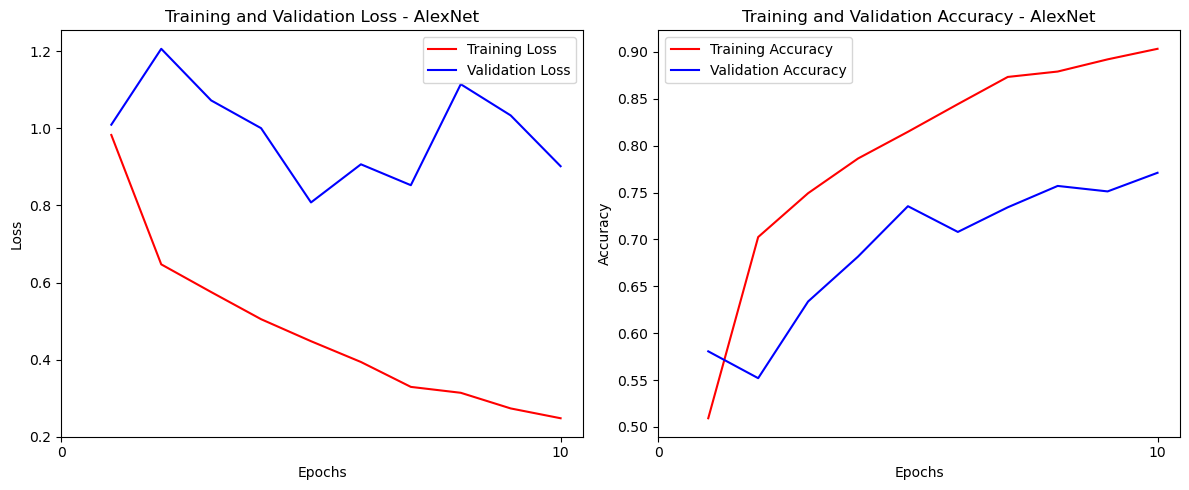

82/82 [==============================] - 18s 216ms/step

Accuracy: 0.7719298245614035
Precision: 0.754311214582652
Recall: 0.7576234567901234
F1-Score: 0.7363928425775204

Classification Report for AlexNet:
               precision    recall  f1-score   support

      glioma       0.71      0.78      0.74       300
  meningioma       0.69      0.33      0.45       306
     notumor       0.84      0.96      0.90       405
   pituitary       0.78      0.95      0.86       300

    accuracy                           0.77      1311
   macro avg       0.75      0.76      0.74      1311
weighted avg       0.76      0.77      0.75      1311



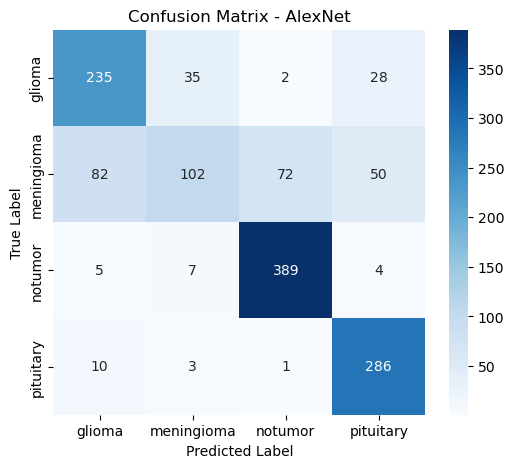

1/1 [==============================] - 0s 345ms/step


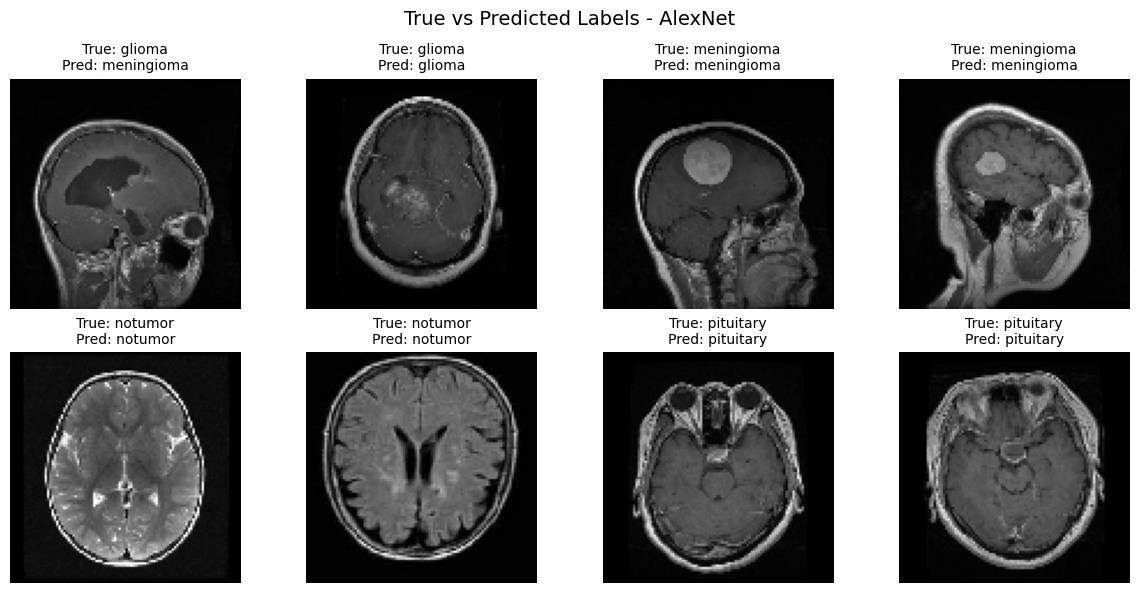

In [21]:
history_alexnet = train_model(alexnet_model, "AlexNet", model_configs["alexnet"])
plot_training_history(history_alexnet, "AlexNet")
evaluate_model(alexnet_model, "AlexNet")

### 3. VGG-16

Epoch 1/50
250/250 [==============================] - 355s 1s/step - loss: 1.0146 - accuracy: 0.5798 - val_loss: 1.0942 - val_accuracy: 0.5841
Epoch 2/50
250/250 [==============================] - 359s 1s/step - loss: 0.6935 - accuracy: 0.7255 - val_loss: 1.0417 - val_accuracy: 0.6355
Epoch 3/50
250/250 [==============================] - 378s 2s/step - loss: 0.6046 - accuracy: 0.7700 - val_loss: 1.0285 - val_accuracy: 0.6472
Epoch 4/50
250/250 [==============================] - 374s 1s/step - loss: 0.5395 - accuracy: 0.7952 - val_loss: 1.0217 - val_accuracy: 0.6542
Epoch 5/50
250/250 [==============================] - 368s 1s/step - loss: 0.5120 - accuracy: 0.8077 - val_loss: 1.0080 - val_accuracy: 0.6665
Epoch 6/50
250/250 [==============================] - 369s 1s/step - loss: 0.4790 - accuracy: 0.8145 - val_loss: 0.9869 - val_accuracy: 0.6840
Epoch 7/50
250/250 [==============================] - 370s 1s/step - loss: 0.4627 - accuracy: 0.8213 - val_loss: 0.9535 - val_accuracy: 0.6893

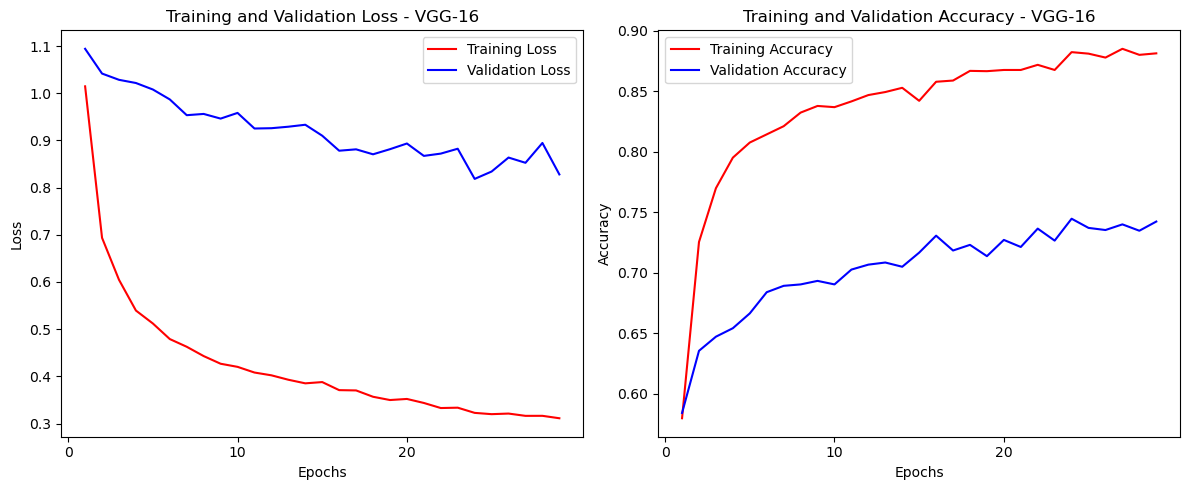

82/82 [==============================] - 81s 978ms/step

Accuracy: 0.7925247902364607
Precision: 0.7860798614568156
Recall: 0.7835039941902686
F1-Score: 0.7821798333674705

Classification Report for VGG-16:
               precision    recall  f1-score   support

      glioma       0.84      0.70      0.76       300
  meningioma       0.65      0.61      0.63       306
     notumor       0.85      0.91      0.88       405
   pituitary       0.81      0.92      0.86       300

    accuracy                           0.79      1311
   macro avg       0.79      0.78      0.78      1311
weighted avg       0.79      0.79      0.79      1311



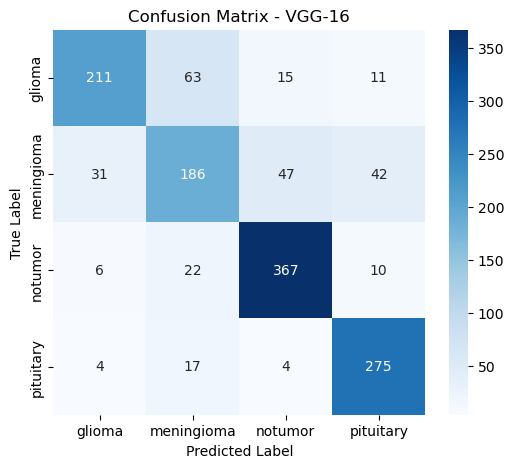

1/1 [==============================] - 1s 1s/step


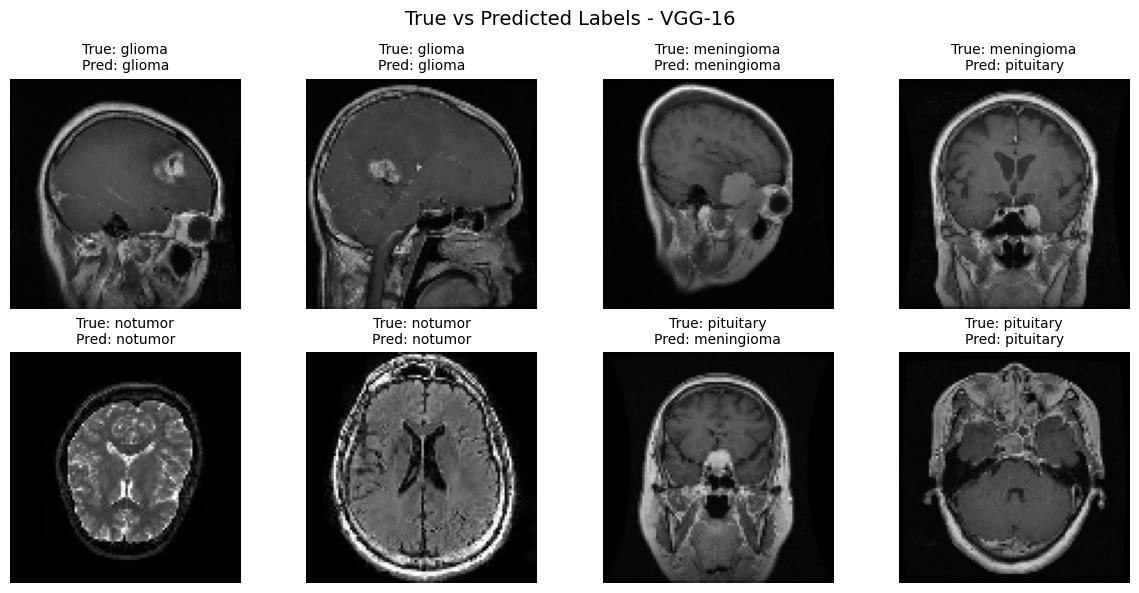

In [22]:
history_vgg = train_model(vgg_model, "VGG-16", model_configs["vgg"])
plot_training_history(history_vgg, "VGG-16")
evaluate_model(vgg_model, "VGG-16")

### 4. ResNet-50

Epoch 1/50
250/250 [==============================] - 215s 808ms/step - loss: 1.3511 - accuracy: 0.3705 - val_loss: 1.2400 - val_accuracy: 0.4813
Epoch 2/50
250/250 [==============================] - 199s 795ms/step - loss: 1.1727 - accuracy: 0.4530 - val_loss: 1.1941 - val_accuracy: 0.5164
Epoch 3/50
250/250 [==============================] - 198s 791ms/step - loss: 1.0945 - accuracy: 0.5190 - val_loss: 1.1812 - val_accuracy: 0.5193
Epoch 4/50
250/250 [==============================] - 205s 819ms/step - loss: 1.0582 - accuracy: 0.5337 - val_loss: 1.1480 - val_accuracy: 0.5695
Epoch 5/50
250/250 [==============================] - 198s 790ms/step - loss: 1.0173 - accuracy: 0.5740 - val_loss: 1.1534 - val_accuracy: 0.5520
Epoch 6/50
250/250 [==============================] - 199s 797ms/step - loss: 1.0068 - accuracy: 0.5695 - val_loss: 1.1319 - val_accuracy: 0.5310
Epoch 7/50
250/250 [==============================] - 209s 835ms/step - loss: 0.9770 - accuracy: 0.5835 - val_loss: 1.1378 -

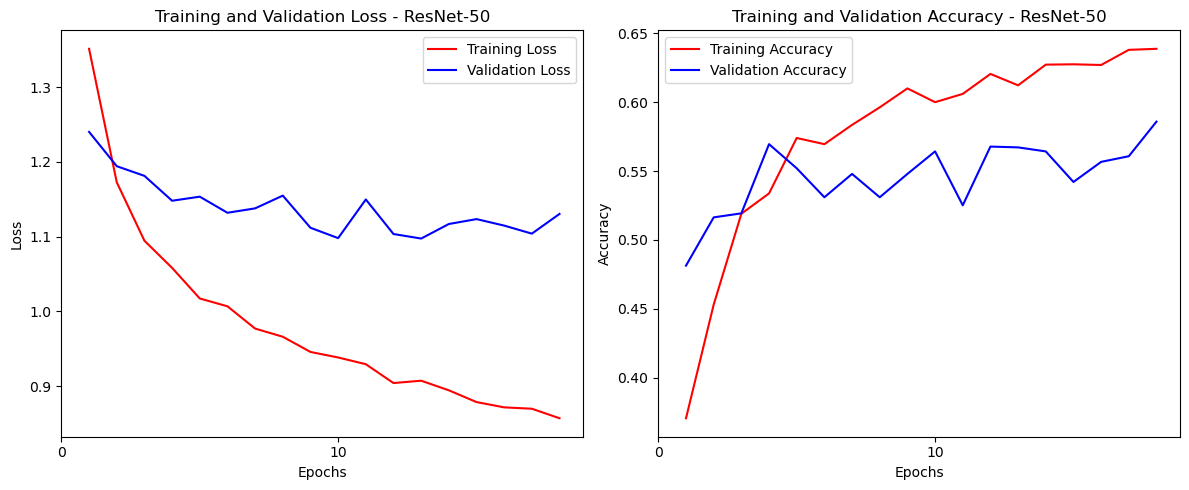

82/82 [==============================] - 64s 762ms/step

Accuracy: 0.5697940503432495
Precision: 0.5588069974222296
Recall: 0.5628467683369643
F1-Score: 0.5505817347750708

Classification Report for ResNet-50:
               precision    recall  f1-score   support

      glioma       0.52      0.54      0.53       300
  meningioma       0.49      0.31      0.38       306
     notumor       0.70      0.66      0.68       405
   pituitary       0.52      0.74      0.62       300

    accuracy                           0.57      1311
   macro avg       0.56      0.56      0.55      1311
weighted avg       0.57      0.57      0.56      1311



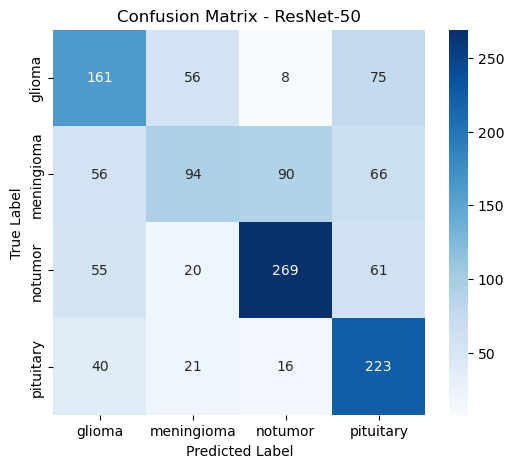

1/1 [==============================] - 4s 4s/step


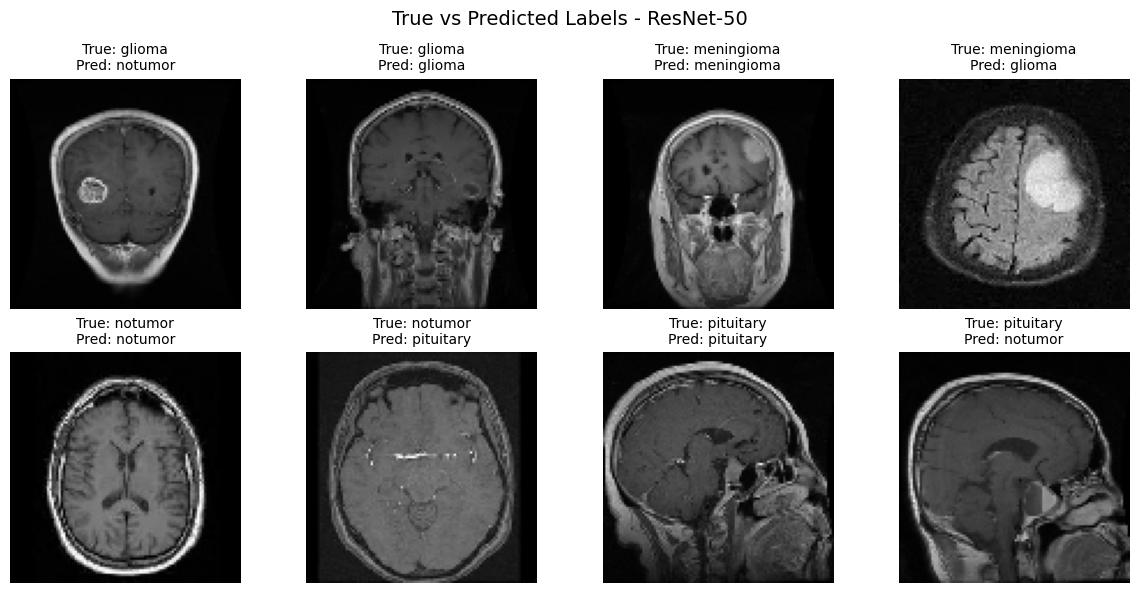

In [23]:
history_resnet = train_model(resnet_model, "ResNet-50", model_configs["resnet"])
plot_training_history(history_resnet, "ResNet-50")
evaluate_model(resnet_model, "ResNet-50")

### 5. InceptionV3

Epoch 1/50


250/250 [==============================] - 140s 495ms/step - loss: 0.7929 - accuracy: 0.6898 - val_loss: 1.0228 - val_accuracy: 0.6501
Epoch 2/50
250/250 [==============================] - 118s 473ms/step - loss: 0.5222 - accuracy: 0.7922 - val_loss: 0.9207 - val_accuracy: 0.6893
Epoch 3/50
250/250 [==============================] - 121s 485ms/step - loss: 0.4665 - accuracy: 0.8167 - val_loss: 0.8625 - val_accuracy: 0.7027
Epoch 4/50
250/250 [==============================] - 120s 472ms/step - loss: 0.4109 - accuracy: 0.8350 - val_loss: 0.8837 - val_accuracy: 0.7103
Epoch 5/50
250/250 [==============================] - 112s 450ms/step - loss: 0.3842 - accuracy: 0.8490 - val_loss: 0.9360 - val_accuracy: 0.6828
Epoch 6/50
250/250 [==============================] - 119s 476ms/step - loss: 0.3782 - accuracy: 0.8580 - val_loss: 0.9111 - val_accuracy: 0.7255
Epoch 7/50
250/250 [==============================] - 116s 463ms/step - loss: 0.3687 - accuracy: 0.8605 - val_loss: 0.9175

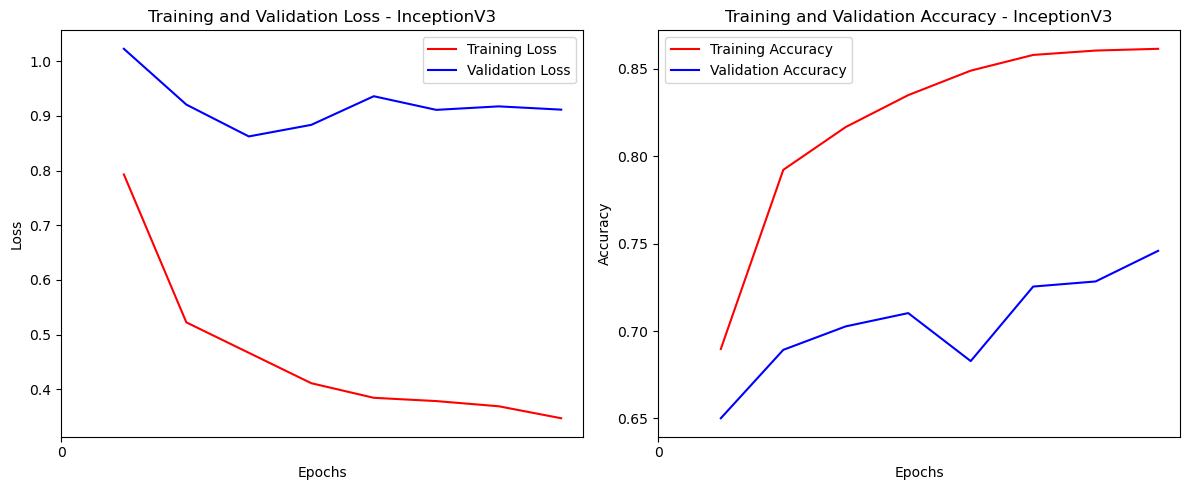

82/82 [==============================] - 30s 304ms/step

Accuracy: 0.7734553775743707
Precision: 0.7752738250908533
Recall: 0.7636564996368919
F1-Score: 0.7641440288881858

Classification Report for InceptionV3:
               precision    recall  f1-score   support

      glioma       0.84      0.62      0.72       300
  meningioma       0.58      0.67      0.62       306
     notumor       0.90      0.89      0.89       405
   pituitary       0.78      0.87      0.82       300

    accuracy                           0.77      1311
   macro avg       0.78      0.76      0.76      1311
weighted avg       0.78      0.77      0.77      1311



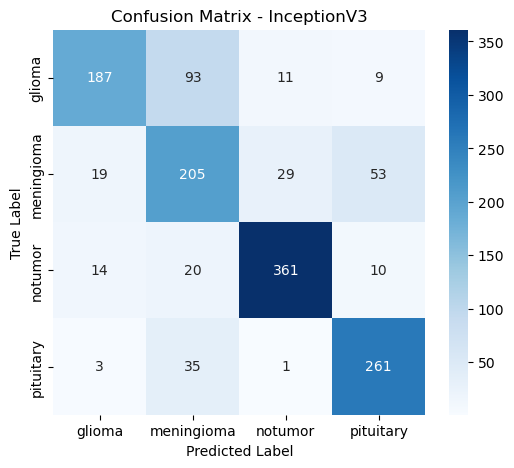

1/1 [==============================] - 4s 4s/step


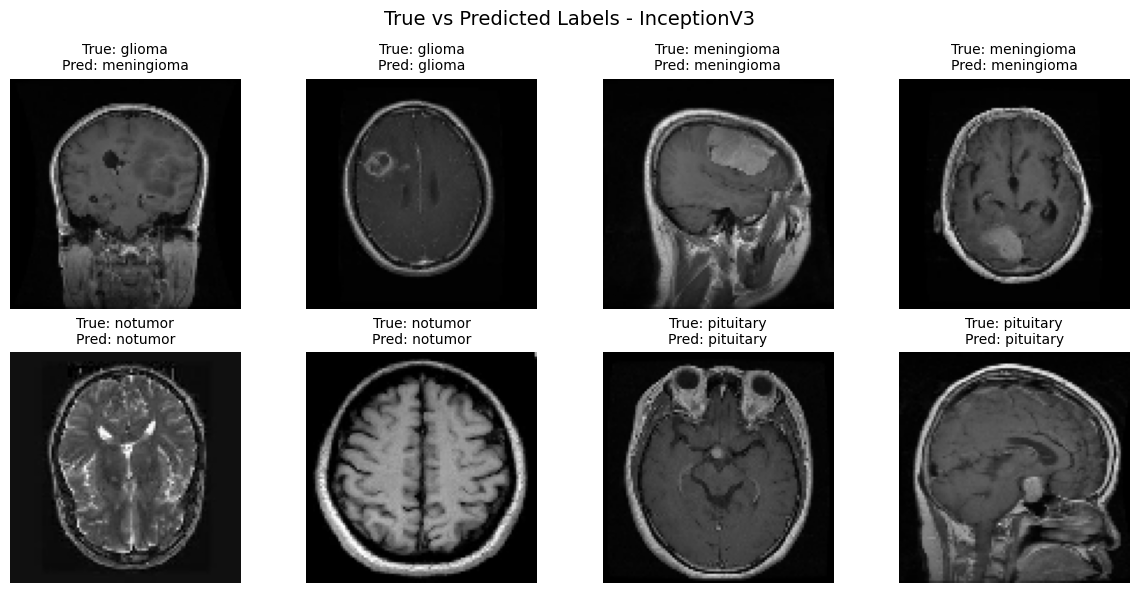

In [20]:
history_inception = train_model(inception_model, "InceptionV3", model_configs["inception"])
plot_training_history(history_inception, "InceptionV3")
evaluate_model(inception_model, "InceptionV3")

In [26]:
data = {
    "CNN": {
        "Accuracy": 86.80,
        "Precision": 87.37,
        "Recall": 86.10,
        "F1-Score": 86.10
    },
    "AlexNet": {
        "Accuracy": 77.19,
        "Precision": 75.43,
        "Recall": 75.76,
        "F1-Score": 73.63
    },
    "VGG-16": {
        "Accuracy": 79.25,
        "Precision": 78.60,
        "Recall": 78.35,
        "F1-Score": 78.21
    },
    "ResNet-50": {
        "Accuracy": 56.97,
        "Precision": 55.88,
        "Recall": 56.28,
        "F1-Score": 55.05
    },
    "InceptionV3": {
        "Accuracy": 77.34,
        "Precision": 77.52,
        "Recall": 76.36,
        "F1-Score": 76.41
    }
}

df = pd.DataFrame(data).T
print(df)

             Accuracy  Precision  Recall  F1-Score
CNN             86.80      87.37   86.10     86.10
AlexNet         77.19      75.43   75.76     73.63
VGG-16          79.25      78.60   78.35     78.21
ResNet-50       56.97      55.88   56.28     55.05
InceptionV3     77.34      77.52   76.36     76.41


In [27]:
df

,Accuracy,Precision,Recall,F1-Score
CNN,86.80,87.37,86.10,86.10
AlexNet,77.19,75.43,75.76,73.63
VGG-16,79.25,78.60,78.35,78.21
ResNet-50,56.97,55.88,56.28,55.05
InceptionV3,77.34,77.52,76.36,76.41
